In [3]:
import pandas as pd
from tqdm import tqdm
import os
import pickle
import cv2
from hand_tracker import HandTracker
import numpy as np

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
# 基础配置
root_dir = 'D:\\jester\\'
data_dir = 'D:\\jester\\data\\'
label_fn = 'jester-v1-labels.csv'
train_fn = 'jester-v1-train.csv'
test_fn = 'jester-v1-test.csv'
valid_fn = 'jester-v1-validation.csv'

train_output_fn = 'C:\\Users\\zys98\\Desktop\\graduation\\github-repo\\sk_dd_2019\\codes\\data\\JESTER\\train.pkl'
valid_output_fn = 'C:\\Users\\zys98\\Desktop\\graduation\\github-repo\\sk_dd_2019\\codes\\data\\JESTER\\valid.pkl'

train_size = 40000
valid_size = 4000

joint_num = 21
joint_dim = 2

In [5]:
# 模型相关初始化
palm_model_path = ".\\models\\palm_detection.tflite"
landmark_model_path = ".\\models\\hand_landmark.tflite"
anchors_path = ".\\data\\anchors.csv" 
# box_shift determines 
from hand_tracker import HandTracker
detector = HandTracker(palm_model_path, landmark_model_path, anchors_path,
                       box_shift=0.2, box_enlarge=1.3)
hand_pres_thresh = 1e-7 # 手部landmark评分的丢弃阈值

hand tracker built ok


In [6]:
# 加载动作类别
cls_csv = pd.read_csv(root_dir + label_fn, sep=';')
cls_dict = dict(zip(cls_csv.clsid, cls_csv.clsname))
cls_dict_verse = dict(zip(cls_csv.clsname, cls_csv.clsid))
# print(cls_dict[1], cls_dict_verse['Swiping Left'])

In [7]:
print(cls_dict)

{1: 'Swiping Left', 2: 'Swiping Right', 3: 'Swiping Down', 4: 'Swiping Up', 5: 'Pushing Hand Away', 6: 'Pulling Hand In', 7: 'Sliding Two Fingers Left', 8: 'Sliding Two Fingers Right', 9: 'Sliding Two Fingers Down', 10: 'Sliding Two Fingers Up', 11: 'Pushing Two Fingers Away', 12: 'Pulling Two Fingers In', 13: 'Rolling Hand Forward', 14: 'Rolling Hand Backward', 15: 'Turning Hand Clockwise', 16: 'Turning Hand Counterclockwise', 17: 'Zooming In With Full Hand', 18: 'Zooming Out With Full Hand', 19: 'Zooming In With Two Fingers', 20: 'Zooming Out With Two Fingers', 21: 'Thumb Up', 22: 'Thumb Down', 23: 'Shaking Hand', 24: 'Stop Sign', 25: 'Drumming Fingers', 26: 'No gesture', 27: 'Doing other things'}


## 加载训练集

In [8]:
try:
    Train = pickle.load(open(train_output_fn, "rb")) # 先加载一波旧数据
except:
    Train = {}
    Train['pose'] = []
    Train['label'] = []
    
print(len(Train['label']))

30860


In [7]:
# 多线程调用detector处理图像
import threading
class DetectorThread(threading.Thread):
    def __init__(self, timage, tdetector):
        threading.Thread.__init__(self)
        self.result = None
        self.image = timage
        self.detector = tdetector
    def run(self):
        kp, box, confidence = self.detector(self.image)
        if kp is None or confidence < hand_pres_thresh:        
            # 暂时按0处理
            kp = np.zeros(joint_dim * joint_num)
        else:
            kp = kp.reshape(joint_dim * joint_num)
        self.result = kp

class MulthreadDetector():
    def __init__(self):
        self.threadNum = 2
        self.detectors = []
        for i in range(self.threadNum):
            self.detectors.append(HandTracker(palm_model_path, landmark_model_path, anchors_path,
                       box_shift=0.2, box_enlarge=1.3))
        # TODO: 创建多个detector
    def __call__(self,skeleton_list, images):
        image_count = 0
        while image_count < len(images):
            # 开启线程
            threads = []
                
            for i in range(self.threadNum):
                if image_count + i >= len(images):
                    break
                thread = DetectorThread(images[image_count + i], self.detectors[i])
                threads.append(thread)
                thread.start()
                
            # 回收线程并获取结果
            for i in range(self.threadNum):
                if image_count + i >= len(images):
                    break
                threads[i].join()
                skeleton_list[image_count + i] = threads[i].result
            image_count += self.threadNum

In [8]:
# 加载训练集
train_data = pd.read_csv(root_dir + train_fn, sep=';')
train_dict = dict(zip(train_data.id, train_data.clsid))
multhreadDetector = MulthreadDetector()

save_count = 0

for index in tqdm(list(train_dict.items())[len(Train['label']):train_size]):
    image_path = data_dir + str(index[0])
    image_file_list = os.listdir(image_path)    
    # 逐个加载并用 HandTracker 得出骨架数据
    skeleton_list = np.empty((len(image_file_list),(joint_dim * joint_num)), dtype = float, order = 'C')
    image_list = []
    for file_index in range(len(image_file_list)):
        file = image_file_list[file_index]
        image = cv2.imread(image_path + '\\' + file)[:,:,::-1]
        image = cv2.resize(image,(256,256)) # resize 为 mediapipe 处理的格式，且实时检测也要保持这个
        image_list.append(image)
    multhreadDetector(skeleton_list, image_list)
    Train['pose'].append(skeleton_list)
    Train['label'].append(index[1])

    save_count += 1
    if save_count % 50 == 0:
        pickle.dump(Train, open(train_output_fn, "wb"))

# TODO: 空骨架 --> 开头(0,0,0)，中间插值
# TODO: 中值滤波

hand tracker built ok
hand tracker built ok


  0%|                                                                                         | 0/9273 [00:00<?, ?it/s]C:\Users\zys98\Desktop\graduation\github-repo\gg_handtracking\python-handtracking\hand_tracker.py:104: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x) )
  1%|█                                                                           | 133/9273 [26:14<30:03:17, 11.84s/it]

KeyboardInterrupt: 

In [ ]:
# 加载训练集
train_data = pd.read_csv(root_dir + train_fn, sep=';')
train_dict = dict(zip(train_data.id, train_data.clsid))

save_count = 0

for index in tqdm(list(train_dict.items())[len(Train['label']):train_size]):
    image_path = data_dir + str(index[0])
    image_file_list = os.listdir(image_path)    
    # 逐个加载并用 HandTracker 得出骨架数据
    skeleton_list = np.empty((len(image_file_list),(joint_dim * joint_num)), dtype = float, order = 'C')
    for file_index in range(len(image_file_list)):
        file = image_file_list[file_index]
        image = cv2.imread(image_path + '\\' + file)[:,:,::-1]
        image = cv2.resize(image,(256,256)) # resize 为 mediapipe 处理的格式，且实时检测也要保持这个
        kp, box, confidence = detector(image)
        if kp is None or confidence < hand_pres_thresh:        
            # 暂时按0处理
            kp = np.zeros(joint_dim * joint_num)
        else:
            kp = kp.reshape(joint_dim * joint_num)
        skeleton_list[file_index] = kp
    Train['pose'].append(skeleton_list)
    Train['label'].append(index[1])

    save_count += 1
    if save_count % 50 == 0:
        pickle.dump(Train, open(train_output_fn, "wb"))

# TODO: 空骨架 --> 开头(0,0,0)，中间插值
# TODO: 中值滤波

In [9]:
# Train数据保存到pickle文件
print('已保存训练数据:', len(Train['label']))
pickle.dump(Train, open(train_output_fn, "wb"))

已保存训练数据: 30860


## 加载验证集

In [9]:
try:
    Valid = pickle.load(open(valid_output_fn, "rb")) # 先加载一波旧数据
except:
    Valid = {}
    Valid['pose'] = []
    Valid['label'] = []
    
print(len(Valid['label']))

4000


In [ ]:
# 加载验证集

valid_data = pd.read_csv(root_dir + valid_fn, sep=';')
valid_dict = dict(zip(valid_data.id, valid_data.clsid))

save_count = 0

for index in tqdm(list(valid_dict.items())[len(Valid['label']):valid_size]):
    image_path = data_dir + str(index[0])
    image_file_list = os.listdir(image_path)    
    # 逐个加载并用 HandTracker 得出骨架数据
    skeleton_list = np.empty((len(image_file_list),(joint_dim * joint_num)), dtype = float, order = 'C')
    for file_index in range(len(image_file_list)):
        file = image_file_list[file_index]
        image = cv2.imread(image_path + '\\' + file)[:,:,::-1]
        image = cv2.resize(image,(256,256)) # resize 为 mediapipe 处理的格式，且实时检测也要保持这个
        kp, box, confidence = detector(image)
        if kp is None or confidence < hand_pres_thresh:     
            # 暂时按0处理
            kp = np.zeros(joint_dim * joint_num)
        else:
            kp = kp.reshape(joint_dim * joint_num)
        skeleton_list[file_index] = kp
    Valid['pose'].append(skeleton_list)
    Valid['label'].append(index[1])

    save_count += 1
    if save_count % 50 == 0:
        pickle.dump(Valid, open(valid_output_fn, "wb"))


# TODO: 空骨架 --> 开头(0,0,0)，中间插值
# TODO: 中值滤波

In [48]:
# Valid数据保存到pickle文件
print('已保存验证数据:', len(Valid['label']))
pickle.dump(Valid, open(valid_output_fn, "wb"))

已保存验证数据: 4000


## 删除空frame的数据

In [10]:

# 训练集
train_noempty_output_fn = 'C:\\Users\\zys98\\Desktop\\graduation\\github-repo\\sk_dd_2019\\codes\\data\\JESTER\\train_noempty.pkl'
Train_NoEmpty = pickle.load(open(train_output_fn, "rb")) # 先加载一波旧数据
poses = Train_NoEmpty['pose']

for pose_index in tqdm(range(len(poses))):
    frame_index = 0
    while frame_index < len(poses[pose_index]):
        if poses[pose_index][frame_index][0] == 0:
            poses[pose_index] = np.delete(poses[pose_index], frame_index, axis=0)
        else:
            frame_index += 1
    if len(poses[pose_index]) == 0:
        poses[pose_index] = np.zeros((1,joint_num*joint_dim))
    pose = np.zeros((1,joint_num*joint_dim))
    
print('已保存(无空帧)训练数据:', len(Train_NoEmpty['label']))
pickle.dump(Train_NoEmpty, open(train_noempty_output_fn, "wb"))

100%|██████████████████████████████████████████████████████████████████████████| 30860/30860 [00:15<00:00, 2049.45it/s]


已保存(无空帧)训练数据: 30860


In [11]:
# 验证集
valid_noempty_output_fn = 'C:\\Users\\zys98\\Desktop\\graduation\\github-repo\\sk_dd_2019\\codes\\data\\JESTER\\valid_noempty.pkl'
Valid_NoEmpty = pickle.load(open(valid_output_fn, "rb")) # 先加载一波旧数据
poses = Valid_NoEmpty['pose']

for pose_index in tqdm(range(len(poses))):
    frame_index = 0
    while frame_index < len(poses[pose_index]):
        if poses[pose_index][frame_index][0] == 0:
            poses[pose_index] = np.delete(poses[pose_index], frame_index, axis=0)
        else:
            frame_index += 1
    if len(poses[pose_index]) == 0:
        poses[pose_index] = np.zeros((1,joint_num*joint_dim))
    pose = np.zeros((1,joint_num*joint_dim))
    
print('已保存(无空帧)验证数据:', len(Valid_NoEmpty['label']))
pickle.dump(Valid_NoEmpty, open(valid_noempty_output_fn, "wb"))

100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:02<00:00, 1996.37it/s]


已保存(无空帧)验证数据: 4000


## 1-6 class 删除空骨架帧 的数据

In [12]:
# 训练集
train_1to6_output_fn = 'C:\\Users\\zys98\\Desktop\\graduation\\github-repo\\sk_dd_2019\\codes\\data\\JESTER\\train_1to6.pkl'
Train_1to6 = pickle.load(open(train_noempty_output_fn, "rb")) # 先加载一波旧数据
poses = Train_1to6['pose']
labels = Train_1to6['label']
pose_index=0
max_cls = 6

while pose_index < len(labels):
    if labels[pose_index] <= max_cls:
        pose_index += 1
    else:
        poses.pop(pose_index)
        labels.pop(pose_index)

print('已保存(class 1-6)训练数据:', len(Train_1to6['label']))
pickle.dump(Train_1to6, open(train_1to6_output_fn, "wb"))

已保存(class 1-6)训练数据: 6328


In [13]:
# 验证集
valid_1to6_output_fn = 'C:\\Users\\zys98\\Desktop\\graduation\\github-repo\\sk_dd_2019\\codes\\data\\JESTER\\valid_1to6.pkl'
Valid_1to6 = pickle.load(open(valid_noempty_output_fn, "rb")) # 先加载一波旧数据
poses = Valid_1to6['pose']
labels = Valid_1to6['label']
pose_index=0
max_cls = 6

while pose_index < len(labels):
    if labels[pose_index] <= max_cls:
        pose_index += 1
    else:
        poses.pop(pose_index)
        labels.pop(pose_index)

print('已保存(class 1-6)验证数据:', len(Valid_1to6['label']))
pickle.dump(Valid_1to6, open(valid_1to6_output_fn, "wb"))

已保存(class 1-6)验证数据: 792


## 分类数 [1, N]；非空帧数 [K, ) 的数据

In [12]:
thresh_frame_num = 5 # 非空帧数 (0即所有)
thresh_frame_rate = 0.3 # 非空帧占比 (0即所有)
max_cls = 20 # class最大数
rootdir = 'C:\\Users\\zys98\\Desktop\\graduation\\github-repo\\sk_dd_2019\\codes\\data\\JESTER\\'

count = 0
for i in range(len(Train_NoEmpty['pose'])):
    data = Train_NoEmpty['pose'][i]
    odata = Train['pose'][i]
#     print(i,data.shape[0])
    if data.shape[0]/odata.shape[0] >= thresh_frame_rate:
        count += 1

print('非空阈值样本占比', count/len(Train_NoEmpty['pose']))


# 训练集
train_noempty_fn = 'train_noempty.pkl'
train_gt20_1to6_fn = 'train_gt20_1to6.pkl'
Train_GT20_1to6 = pickle.load(open(rootdir + train_noempty_fn, "rb")) # 先加载一波旧数据
poses = Train_GT20_1to6['pose']
oposes = Train['pose']
labels = Train_GT20_1to6['label']
pose_index=0

while pose_index < len(labels):
    if labels[pose_index] <= max_cls and poses[pose_index].shape[0] >= thresh_frame_num and poses[pose_index].shape[0]/oposes[pose_index].shape[0] >= thresh_frame_rate:
        pose_index += 1
    else:
        poses.pop(pose_index)
        labels.pop(pose_index)
    
print('已保存(1-'+str(max_cls)+' class 非空帧数 > '+str(thresh_frame_num)+' 的数据)训练数据:', len(Train_GT20_1to6['label']))
pickle.dump(Train_GT20_1to6, open(rootdir + train_gt20_1to6_fn, "wb"))

# 验证集
valid_noempty_fn = 'valid_noempty.pkl'
valid_gt20_1to6_fn = 'valid_gt20_1to6.pkl'
Valid_GT20_1to6 = pickle.load(open(rootdir + valid_noempty_fn, "rb")) # 先加载一波旧数据
poses = Valid_GT20_1to6['pose']
oposes = Valid['pose']
labels = Valid_GT20_1to6['label']
pose_index=0

while pose_index < len(labels):
    if labels[pose_index] <= max_cls and poses[pose_index].shape[0] >= thresh_frame_num  and poses[pose_index].shape[0]/oposes[pose_index].shape[0] >= thresh_frame_rate:
        pose_index += 1
    else:
        poses.pop(pose_index)
        labels.pop(pose_index)
    
print('已保存(1-'+str(max_cls)+' class 非空帧数 > '+str(thresh_frame_num)+' 的数据)验证数据:', len(Valid_GT20_1to6['label']))
pickle.dump(Valid_GT20_1to6, open(rootdir + valid_gt20_1to6_fn, "wb"))

非空阈值样本占比 0.20946208684381076
已保存(1-20 class 非空帧数 > 5 的数据)训练数据: 4564
已保存(1-20 class 非空帧数 > 5 的数据)验证数据: 511


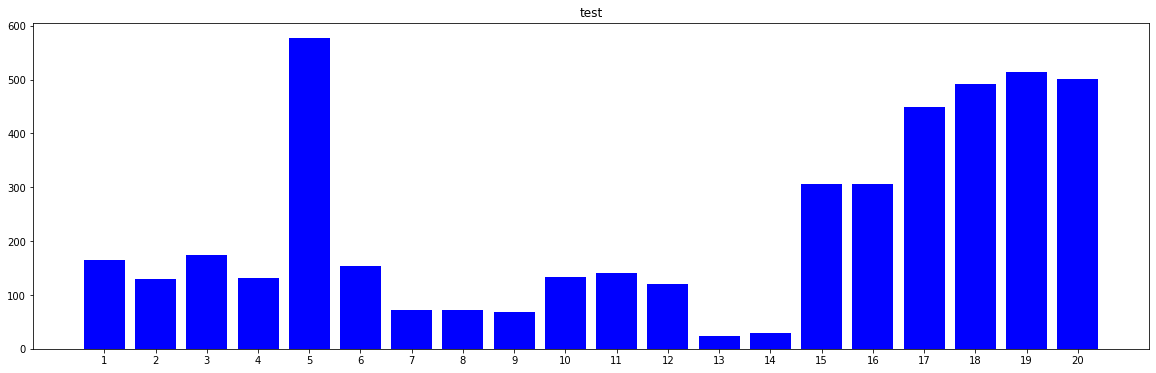

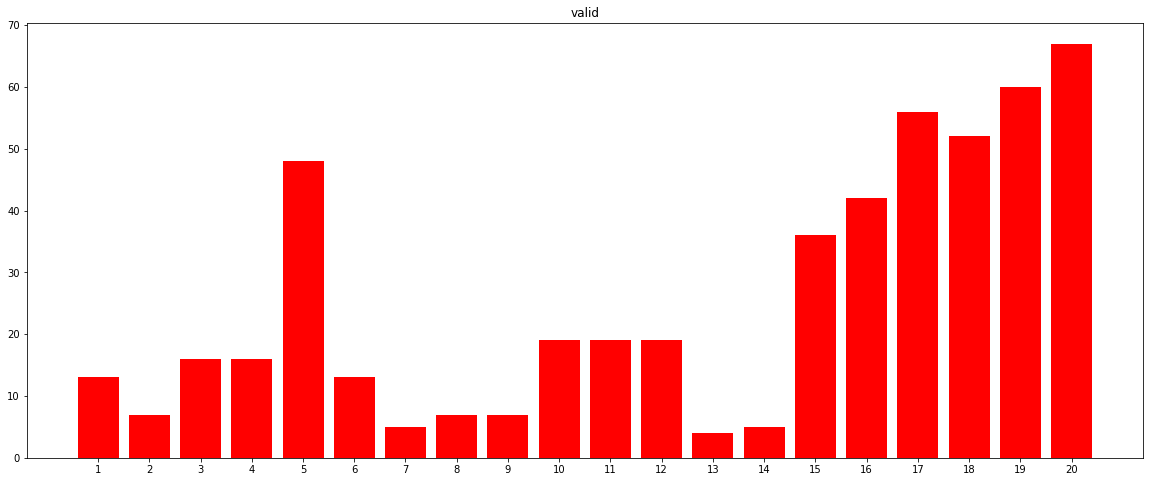

In [13]:
# 折线图显示数据分布

import matplotlib.pyplot as plt
import numpy as np  

fig_test = dict(zip(range(1,max_cls+1),(0 for _ in range(max_cls))))
fig_valid = dict(zip(range(1,max_cls+1),(0 for _ in range(max_cls))))
for i in Train_GT20_1to6['label']:
    fig_test[i] += 1
for i in Valid_GT20_1to6['label']:
    fig_valid[i] += 1

plt.figure(figsize=(20, 6))
keys=fig_test.keys()
y=fig_test.values()
x=range(len(keys))

plt.bar(x,y,color='blue')
plt.xticks(x, keys)
plt.title("test")
plt.show()

plt.figure(figsize=(20, 8))
keys=fig_valid.keys()
y=fig_valid.values()
x=range(len(keys))

plt.bar(x,y,color='red')
plt.xticks(x, keys)
plt.title("valid")
plt.show()

In [14]:
# 平衡数据

# 训练集
ly = list(fig_test.values())
ly.sort()
minV = ly[int(len(ly)/2)]
stayPos = []
for i in fig_test.values():
    if i != 0:
        stayPos.append(minV/i)
    else:
        stayPos.append(0)
print(stayPos)
poses = Train_GT20_1to6['pose']
labels = Train_GT20_1to6['label']

import random
random.seed(20)
pose_index = 0
while pose_index < len(labels):
    if random.random() < stayPos[labels[pose_index]-1]:
        pose_index += 1
    else:
        poses.pop(pose_index)
        labels.pop(pose_index)
        
# 验证集

ly = list(fig_valid.values())
ly.sort()
minV = ly[int(len(ly)/2)]
stayPos = []
for i in fig_valid.values():
    if i != 0:
        stayPos.append(minV/i)
    else:
        stayPos.append(0)
print(stayPos)
poses = Valid_GT20_1to6['pose']
labels = Valid_GT20_1to6['label']

pose_index = 0
while pose_index < len(labels):
    if random.random() < stayPos[labels[pose_index]-1]:
        pose_index += 1
    else:
        poses.pop(pose_index)
        labels.pop(pose_index)

# 保存数据
print('已保存平衡后的训练数据:', len(Train_GT20_1to6['label']))
pickle.dump(Train_GT20_1to6, open(rootdir + train_gt20_1to6_fn, "wb"))
    
print('已保存平衡后的验证数据:', len(Valid_GT20_1to6['label']))
pickle.dump(Valid_GT20_1to6, open(rootdir + valid_gt20_1to6_fn, "wb"))

[0.9272727272727272, 1.176923076923077, 0.8742857142857143, 1.16793893129771, 0.2651646447140381, 1.0, 2.125, 2.125, 2.217391304347826, 1.150375939849624, 1.0851063829787233, 1.2644628099173554, 6.375, 5.1, 0.5, 0.5, 0.34, 0.31097560975609756, 0.2970873786407767, 0.3047808764940239]
[1.4615384615384615, 2.7142857142857144, 1.1875, 1.1875, 0.3958333333333333, 1.4615384615384615, 3.8, 2.7142857142857144, 2.7142857142857144, 1.0, 1.0, 1.0, 4.75, 3.8, 0.5277777777777778, 0.4523809523809524, 0.3392857142857143, 0.36538461538461536, 0.31666666666666665, 0.2835820895522388]
已保存平衡后的训练数据: 2456
已保存平衡后的验证数据: 265


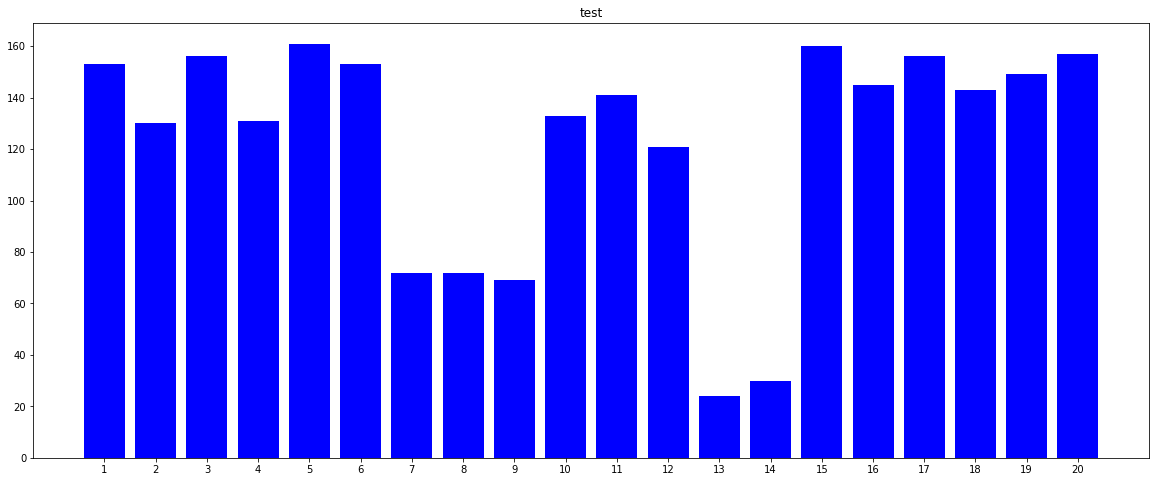

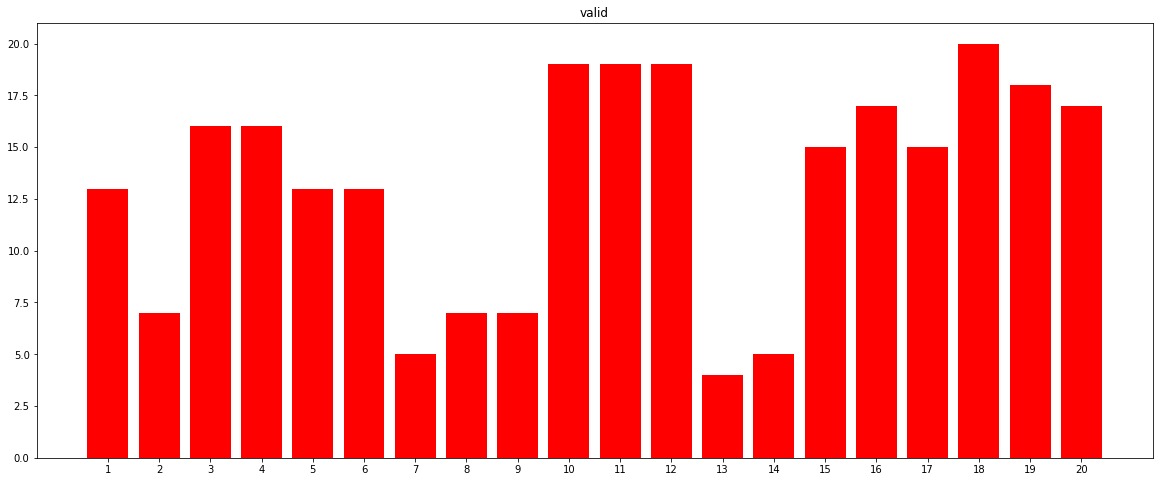

In [15]:
# 折线图显示数据分布

fig_test = dict(zip(range(1,max_cls+1),(0 for _ in range(max_cls))))
fig_valid = dict(zip(range(1,max_cls+1),(0 for _ in range(max_cls))))
for i in Train_GT20_1to6['label']:
    fig_test[i] += 1
for i in Valid_GT20_1to6['label']:
    fig_valid[i] += 1

plt.figure(figsize=(20, 8))
keys=fig_test.keys()
y=fig_test.values()
x=range(len(keys))

plt.bar(x,y,color='blue')
plt.xticks(x, keys)
plt.title("test")
plt.show()

plt.figure(figsize=(20, 8))
keys=fig_valid.keys()
y=fig_valid.values()
x=range(len(keys))

plt.bar(x,y,color='red')
plt.xticks(x, keys)
plt.title("valid")
plt.show()

## 用于统计各数据集空骨架的概率

In [17]:
frame_count = 0
empty_count = 0
all_emtpy = 0
start = 0
end = -1
for pose in Train['pose'][start:end]:
    this_frame = 0
    this_empty = 0
    for frame in pose:
        this_frame += 1
        frame_count += 1
        if frame[0] == 0:
            empty_count += 1
            this_empty += 1
    if this_empty == this_frame:
        all_emtpy += 1
print('总空帧率(%):',empty_count / frame_count * 100)
print('空样本率(%)',all_emtpy / len(Train['pose'][start:end]) * 100)

总空帧率(%): 83.39738214699636
空样本率(%) 36.786674876049126
